<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/holster/VIT_quickdraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Helpful links

# https://github.com/benisalla/Tiny-ViT-Transformer-from-scratch?tab=readme-ov-file#training
# https://github.com/benisalla/Tiny-ViT-Transformer-from-scratch?tab=readme-ov-file#training
# https://medium.com/@tyler_yu/vit-from-scratch-61debb718e99

In [2]:
!pip install torchinfo kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chemauer","key":"029f6a06205bcb5ec29e5a41783a6486"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

Dataset URL: https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification
License(s): CC0-1.0
 97% 422M/435M [00:03<00:00, 112MB/s] 
100% 435M/435M [00:03<00:00, 122MB/s]


In [6]:
!mkdir -p ./data/tom_jerry
!unzip tom-and-jerry-image-classification.zip -d ./data/tom_jerry

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2793.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2794.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2795.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2796.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2797.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2798.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2799.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2800.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2801.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2802.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_jerry/jerry/frame2803.jpg  
  inflating: ./data/tom_jerry/tom_and_jerry/tom_and_j

In [37]:
import torch
from torchinfo import summary
from torch.nn import functional as F
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [54]:
num_channels: int = 3
batch_size:int = 16
image_size: int = 128
patch_size: int = 16
embd_dim: int = 256          # 768
num_heads: int = 4
num_classes: int = 10
num_layers: int = 6
num_patches: int = (image_size // patch_size) ** 2         # 64
dropout: float = 0.0
layer_norm_eps: float = 1e-6
device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TomJerryDataset(Dataset):
    """
    4-class Tom & Jerry dataset based on folder structure.
    """

    CLASS_TO_LABEL = {
        "tom_jerry_0": 0,
        "tom": 1,
        "jerry": 2,
        "tom_jerry_1": 3,
    }

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: path to 'tom_and_jerry'
            transform: torchvision transforms
        """
        self.samples = []
        self.transform = transform

        for class_name, label in self.CLASS_TO_LABEL.items():
            class_dir = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_dir):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    self.samples.append(
                        (os.path.join(class_dir, fname), label)
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label, img_path


In [56]:
from torchvision import transforms

IMAGE_SIZE = 128

train_transform = transforms.Compose([

    transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
          mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5))
 ])

In [57]:
from torch.utils.data import random_split

dataset = TomJerryDataset(
    root_dir="./data/tom_jerry/tom_and_jerry/tom_and_jerry",
    transform=train_transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Important: apply val transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


In [58]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [59]:
next(iter(train_loader))

[tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-

In [60]:
def get_batch(split):
    loader = train_loader if split == "train" else val_loader
    images, labels, paths = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)
    return images, labels, paths

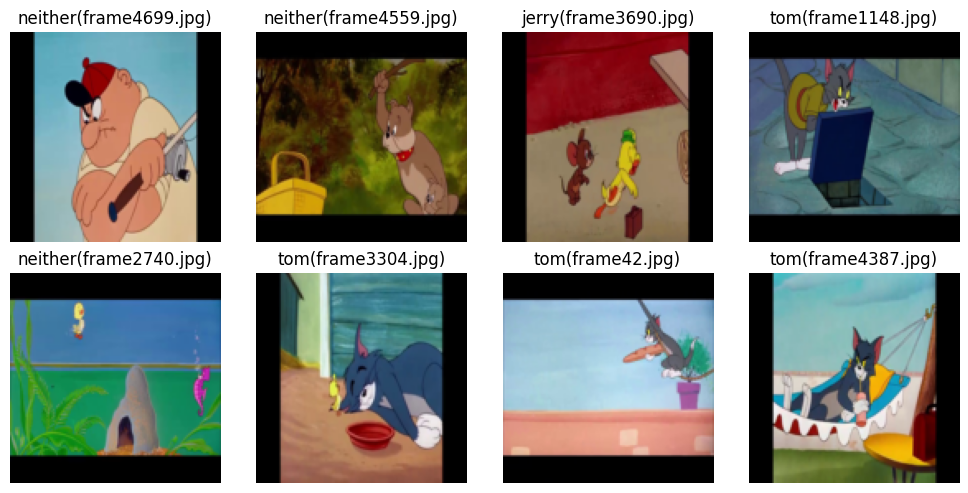

In [61]:
class_names = {
    0: "neither",
    1: "tom",
    2: "jerry",
    3: "tom_and_jerry"
}


images, labels, paths = get_batch("train")

plt.figure(figsize=(10, 5))
for i in range(min(8, images.size(0))):
    plt.subplot(2, 4, i + 1)
    img = images[i].permute(1, 2, 0)
    img = (img * 0.5) + 0.5
    plt.imshow(img)
    plt.title(f"{class_names[labels[i].item()]}({paths[i].split("/")[-1]})")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [62]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, _ = get_batch(split)
            logits = model(X)
            loss = criterion(logits, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

In [63]:
class VisionEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=embd_dim,
                kernel_size=patch_size,
                stride=patch_size,
                padding="valid"
            ),
            nn.Flatten(start_dim=2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embd_dim)), requires_grad=True)
        self.pos_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embd_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        patch_embd = self.patch_embedding(x).transpose(2,1)
        patch_embd = torch.cat([cls_token, patch_embd], dim=1)
        embd = self.pos_embeddings + patch_embd
        embd = self.dropout(embd)
        return embd

In [64]:
class AttentionHead(nn.Module):

    def __init__(self, embed_dim, head_size, dropout=0.0):
        super().__init__()
        self.head_size = head_size  # d_k
        # Linear projections for Q, K, V
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        self.key   = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape  # batch, tokens, embedding

        # Project inputs to Q, K, V
        Q = self.query(x)  # (B, T, head_size)
        K = self.key(x)    # (B, T, head_size)
        V = self.value(x)  # (B, T, head_size)

        # Compute attention scores
        # Q @ K^T per batch
        # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        scores = Q @ K.transpose(-2, -1)
        scores = scores / math.sqrt(self.head_size)  # scale by head_size



        # Softmax to get attention probabilities
        attn_probs = F.softmax(scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Weighted sum of values
        out = attn_probs @ V  # (B, T, head_size)

        return out

In [65]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention for ViT.

    Input:
      x: (B, T, embed_dim)
    Output:
      out: (B, T, embed_dim)
    """

    def __init__(self, embed_dim, num_heads, dropout=0.0):
      super().__init__()
      assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

      self.embed_dim = embed_dim
      self.num_heads = num_heads
      self.head_size = embed_dim // num_heads

      self.heads = nn.ModuleList([
        AttentionHead(embed_dim, self.head_size, dropout)
        for _ in range(num_heads)
      ])

      # Output projection
      self.proj = nn.Linear(embed_dim, embed_dim)
      self.dropout = nn.Dropout(dropout)

    def forward(self, x):
      # Run all heads in parallel
      out = torch.cat([head(x) for head in self.heads], dim=-1)
      # Project back to embed_dim
      out = self.proj(out)
      out = self.dropout(out)
      return out


In [66]:
class FeedForward(nn.Module):
    """
    Feed-forward (MLP) block used in ViT.

    Input:
        x: (B, T, embed_dim)
    Output:
        out: (B, T, embed_dim)
    """

    def __init__(self, embed_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


In [67]:
class AttentionBlock(nn.Module):
    """
    Transformer encoder block for ViT.

    Structure:
        x = x + MHA(LN(x))
        x = x + MLP(LN(x))
    """

    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)

        self.attn = MultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )

        self.ffwd = FeedForward(
            embed_dim=embed_dim,
            dropout=dropout
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [68]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) for image classification.
    """

    def __init__(self):
        super().__init__()

        self.embedding = VisionEmbedding()

        self.blocks = nn.ModuleList([
            AttentionBlock(
                embed_dim=embd_dim,
                num_heads=num_heads,
                dropout=dropout
            )
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(
            embd_dim,
            eps=layer_norm_eps
        )

        self.head = nn.Linear(
            embd_dim,
            num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Patch + position embedding
        x = self.embedding(x)  # (B, T, embd_dim)

        # Transformer encoder
        for block in self.blocks:
            x = block(x)

        # Final normalization
        x = self.ln_f(x)

        # Classification via CLS token
        cls_token = x[:, 0]
        logits = self.head(cls_token)

        return logits

In [69]:
vit = VisionTransformer()
summary(model=vit,
        input_size=(16, 3, 128, 128),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)              [16, 3, 128, 128]    [16, 10]             --                   True
├─VisionEmbedding (embedding)                      [16, 3, 128, 128]    [16, 65, 256]        16,896               True
│    └─Sequential (patch_embedding)                [16, 3, 128, 128]    [16, 256, 64]        --                   True
│    │    └─Conv2d (0)                             [16, 3, 128, 128]    [16, 256, 8, 8]      196,864              True
│    │    └─Flatten (1)                            [16, 256, 8, 8]      [16, 256, 64]        --                   --
│    └─Dropout (dropout)                           [16, 65, 256]        [16, 65, 256]        --                   --
├─ModuleList (blocks)                              --                   --                   --                   True
│    └─AttentionBlock (0)                      

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # optional for progress bar

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)

criterion = nn.CrossEntropyLoss()          # 4-class classification
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
num_epochs = 5  # holster-scale training


In [ ]:
model = VisionTransformer().to(device)

print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=0.01
)

max_iters = 2000
eval_interval = 200
eval_iters = 20

for iteration in range(max_iters):

    if iteration % eval_interval == 0 or iteration == max_iters - 1:
        losses = estimate_loss()
        print(
            f"step {iteration}: "
            f"train loss {losses['train']:.4f}, "
            f"val loss {losses['val']:.4f}"
        )

    xb, yb, _ = get_batch("train")

    logits = model(xb)
    loss = criterion(logits, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


4.950794 M parameters
step 0: train loss 2.3691, val loss 2.3208


In [26]:
torch.save(model.state_dict(), "./vit_tom_jerry")
